In [1]:
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import hub
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchaudio
import torchvision.models as models

import numpy as np
import pandas as pd

from sklearn.metrics import f1_score, recall_score, precision_score, balanced_accuracy_score, accuracy_score, classification_report
from sklearn.utils import shuffle

import scipy

from tqdm import tqdm

from datasets import load_dataset, Dataset, Audio
import librosa
from transformers import AutoFeatureExtractor, Wav2Vec2ForSequenceClassification

# from models.swishnet import SwishNet
from models.cnn import CNNModel

from src.utils import AphasiaDatasetMFCC, AphasiaDatasetSpectrogram, AphasiaDatasetWaveform

from collections import Counter

from torch_audiomentations import Compose, AddColoredNoise, PitchShift, Gain

2025-04-02 20:58:15.955732: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-02 20:58:15.965916: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743616695.978695  169720 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743616695.982202  169720 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-02 20:58:15.995315: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
AUDIO_LENGTH = 6_000
SEQUENCE_LENGTH = 420
MFCC = 128
print(f"It's {DEVICE} time!!!")

It's cuda time!!!


In [3]:
DATA_DIR = os.path.join('..', 'data')
VOICES_DIR = os.path.join(DATA_DIR, 'Voices')
APHASIA_DIR = os.path.join(VOICES_DIR, 'Aphasia')
NORM_DIR = os.path.join(VOICES_DIR, 'Norm')

In [4]:
train_dataset = AphasiaDatasetMFCC(os.path.join(DATA_DIR, "train_filenames.csv"), VOICES_DIR, target_sample_rate=8_000, mfcc=MFCC, n_mels=128, fft_size=512,
                 hop_length=256, win_length=512, min_duration=10, max_duration=15, )
test_dataset = AphasiaDatasetMFCC(os.path.join(DATA_DIR, "val_filenames.csv"), VOICES_DIR, target_sample_rate=8_000, mfcc=MFCC, n_mels=128, fft_size=512,
                 hop_length=256, win_length=512, min_duration=10, max_duration=15)
val_dataset = AphasiaDatasetMFCC(os.path.join(DATA_DIR, "test_filenames.csv"), VOICES_DIR, target_sample_rate=8_000, mfcc=MFCC, n_mels=128, fft_size=512,
                 hop_length=256, win_length=512, min_duration=10, max_duration=15)

# Class balancing for train
train_labels = [label for _, label in train_dataset.data]
class_counts = Counter(train_labels)
if len(class_counts) < 2:
    raise ValueError("One of the classes is missing in the training set")

class_weights = {label: 1.0 / count for label, count in class_counts.items()}
weights = [class_weights[label] for _, label in train_dataset.data]
train_sampler = WeightedRandomSampler(weights, num_samples=len(train_dataset), replacement=True)

In [5]:
def pad_sequence(batch):
    if not batch:
        return torch.zeros(0), torch.zeros(0)
    
    seq, labels = zip(*batch)
    max_len = max(s.shape[1] for s in seq)

    padded = torch.zeros(len(seq), MFCC, SEQUENCE_LENGTH)
    for i, s in enumerate(seq):
        padded[i, ..., :s.shape[-1]] = s[..., :SEQUENCE_LENGTH]
    
    return padded, torch.stack(labels) 

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=16, sampler=train_sampler, collate_fn=pad_sequence, drop_last=True, num_workers=6)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=pad_sequence, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=pad_sequence, drop_last=True, num_workers=6)

In [7]:
def train_model(model, dl_train, dl_val, epochs=1, lr=0.001, device="cpu"):
      
    model = model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
        
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, threshold=1e-3)
        
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    for epoch in tqdm(range(epochs), desc="Training model"):
        model.train()
        total_train_loss = 0
        total_val_loss = 0
        
        train_acc = []
        val_acc = []
        for features, target in dl_train:
            features, target = features.to(device), target.to(device)
            optimizer.zero_grad()
            
            output = model(features.unsqueeze(1)).squeeze()

            preds = torch.argmax(output, dim=1).cpu().detach().numpy()
            train_acc.append(accuracy_score(target.cpu().detach().numpy(), preds))
            
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.detach().item()
        
        avg_train_acc = np.stack(train_acc, axis=0).mean()

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
                
        model.eval()
        
        with torch.no_grad():
            for features, target in dl_val:
                features, target = features.to(device), target.to(device)
                
                output = model(features.unsqueeze(1)).squeeze()
                
                preds = torch.argmax(output, dim=1).cpu().detach().numpy()
                val_acc.append(accuracy_score(target.cpu().detach().numpy(), preds))
                loss = criterion(output, target)
                total_val_loss += loss.detach().item()
        
        avg_val_acc = np.stack(val_acc, axis=0).mean()
        avg_val_loss = total_val_loss / len(dl_val)
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(avg_val_acc)
        
        if scheduler:
            try:
                scheduler.step()
            except:
                scheduler.step(avg_val_loss)
        
        # if epoch % 10 == 0:
        tqdm.write(f"Epoch {epoch}: train loss: {avg_train_loss:.3f}, train balanced acc: {avg_train_acc:.2f}, test loss: {avg_val_loss:.3f}, test balanced acc: {avg_val_acc:.2f}, lr: {optimizer.param_groups[0]['lr']}")

            
    return model, train_loss_list, val_loss_list, train_acc_list, val_acc_list

In [8]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=2, in_channels=1):
        super(CNNModel, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),  # Conv 1
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), # Conv 2
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),

            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), # Conv 3
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), # Conv 4
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),

            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), # Conv 5
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
        )

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Averaging before FC layers

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.global_avg_pool(x)
        x = self.fc_layers(x)
        return x


In [9]:
cnn = CNNModel(num_classes=2, in_channels=1)

In [10]:
cnn, train_l, val_l, train_accuracy, val_accuracy = train_model(cnn, train_dataloader, val_dataloader, epochs=10, lr=1e-3, device=DEVICE)

Training model:  10%|█         | 1/10 [00:28<04:13, 28.17s/it]

Epoch 0: train loss: 0.429, train balanced acc: 0.80, test loss: 0.402, test balanced acc: 0.87, lr: 0.001


Training model:  20%|██        | 2/10 [00:56<03:44, 28.05s/it]

Epoch 1: train loss: 0.310, train balanced acc: 0.87, test loss: 0.231, test balanced acc: 0.89, lr: 0.001


Training model:  30%|███       | 3/10 [01:24<03:16, 28.03s/it]

Epoch 2: train loss: 0.267, train balanced acc: 0.89, test loss: 0.156, test balanced acc: 0.95, lr: 0.001


Training model:  40%|████      | 4/10 [01:52<02:48, 28.03s/it]

Epoch 3: train loss: 0.281, train balanced acc: 0.89, test loss: 0.310, test balanced acc: 0.90, lr: 0.001


Training model:  50%|█████     | 5/10 [02:20<02:20, 28.03s/it]

Epoch 4: train loss: 0.226, train balanced acc: 0.91, test loss: 0.161, test balanced acc: 0.95, lr: 0.001


Training model:  60%|██████    | 6/10 [02:48<01:52, 28.04s/it]

Epoch 5: train loss: 0.206, train balanced acc: 0.92, test loss: 0.162, test balanced acc: 0.95, lr: 0.001


Training model:  70%|███████   | 7/10 [03:16<01:24, 28.05s/it]

Epoch 6: train loss: 0.193, train balanced acc: 0.92, test loss: 0.274, test balanced acc: 0.87, lr: 0.0005


Training model:  80%|████████  | 8/10 [03:44<00:56, 28.06s/it]

Epoch 7: train loss: 0.176, train balanced acc: 0.93, test loss: 0.165, test balanced acc: 0.94, lr: 0.0005


Training model:  90%|█████████ | 9/10 [04:12<00:28, 28.06s/it]

Epoch 8: train loss: 0.149, train balanced acc: 0.95, test loss: 0.239, test balanced acc: 0.93, lr: 0.0005


Training model: 100%|██████████| 10/10 [04:40<00:00, 28.06s/it]

Epoch 9: train loss: 0.163, train balanced acc: 0.94, test loss: 0.238, test balanced acc: 0.90, lr: 0.0005


In [11]:
def test_model(model, test_data):
    model = model.to(DEVICE)
        
    model.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for features, target in tqdm(test_data):
            features = features.to(DEVICE)
            target = target.to(DEVICE)
            
            label = model(features.unsqueeze(1)).to("cpu").detach().numpy().squeeze()
            preds.extend(label.argmax(axis=-1).tolist())
            # print(target.shape)
            targets.extend(target.to("cpu").tolist())

    preds = np.array(preds)
    # print(targets)
    print(classification_report(targets, preds))    

    return preds

In [12]:
test_model(cnn, test_dataloader)

100%|██████████| 52/52 [00:02<00:00, 19.24it/s]

              precision    recall  f1-score   support

           0       0.45      0.99      0.62       106
           1       1.00      0.83      0.90       726

    accuracy                           0.85       832
   macro avg       0.73      0.91      0.76       832
weighted avg       0.93      0.85      0.87       832



array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,

Text(0.5, 0, 'Epoch')

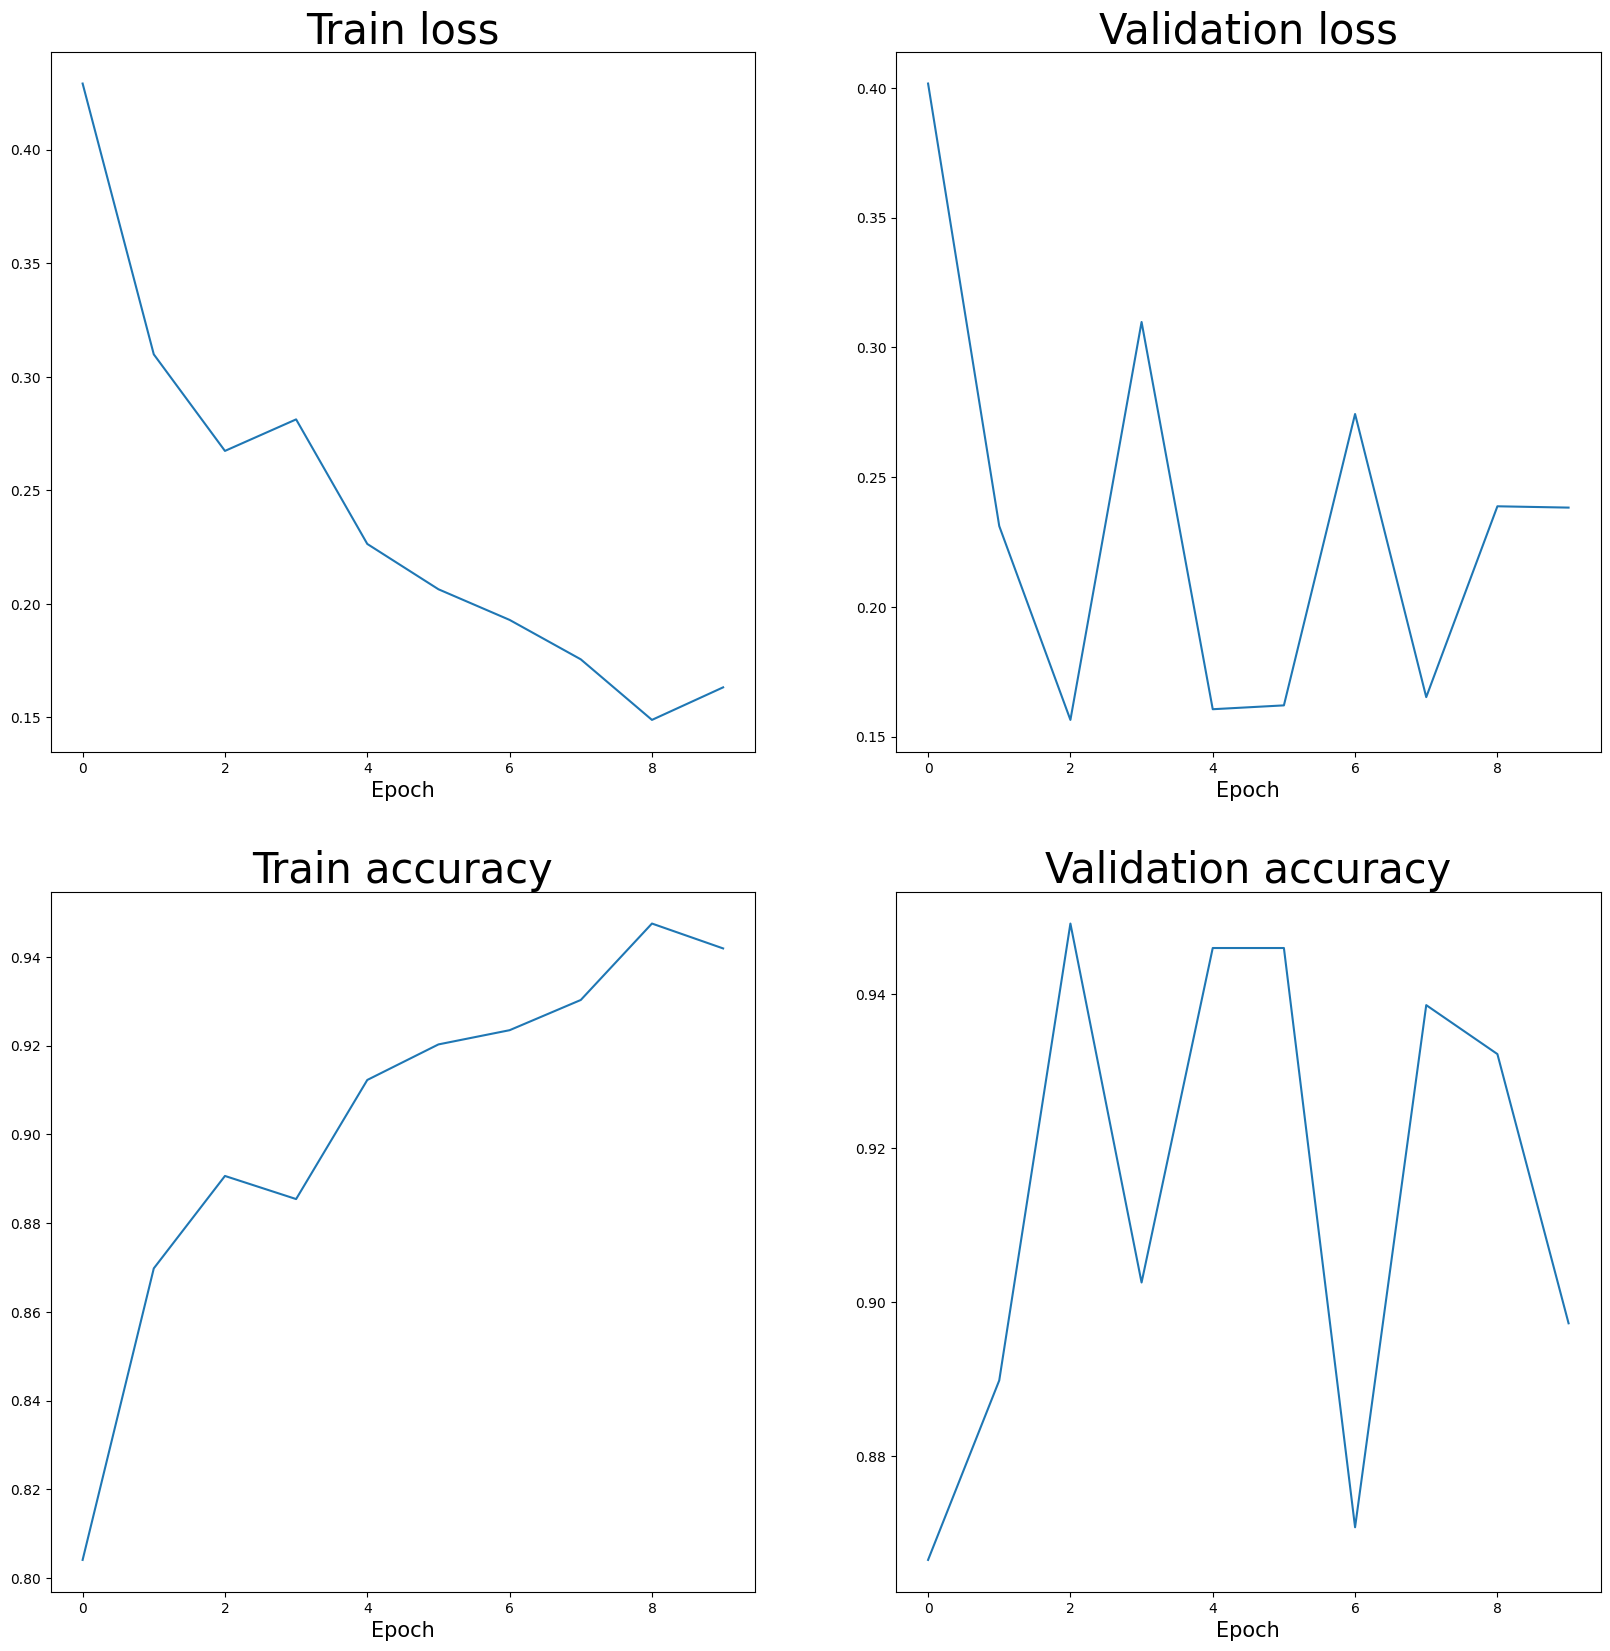

In [13]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

axes[0][0].plot(train_l)
axes[0][0].set_title("Train loss", fontsize=30)
axes[0][0].set_xlabel("Epoch", fontsize=15)

axes[0][1].plot(val_l)
axes[0][1].set_title("Validation loss", fontsize=30)
axes[0][1].set_xlabel("Epoch", fontsize=15)

axes[1][0].plot(train_accuracy)
axes[1][0].set_title("Train accuracy", fontsize=30)
axes[1][0].set_xlabel("Epoch", fontsize=15)

axes[1][1].plot(val_accuracy)
axes[1][1].set_title("Validation accuracy", fontsize=30)
axes[1][1].set_xlabel("Epoch", fontsize=15)

In [14]:
test_data = pd.read_csv(os.path.join(DATA_DIR, 'test_filenames.csv'))
DATA_DIR = os.path.join('..', 'data')
VOICES_DIR = os.path.join(DATA_DIR, 'Voices_wav')
APHASIA_DIR = os.path.join(VOICES_DIR, 'Aphasia')
NORM_DIR = os.path.join(VOICES_DIR, 'Norm')

In [15]:
def test_model_for_each_participant(model, test_data):
    model = model.to("cpu")
        
    model.eval()

    test_data["ID"] = test_data["file_name"].apply(
        lambda x: str(x).split("-")[0] + str(x).split("-")[1])
    test_data.head()
    IDs = test_data["ID"].unique()

    all_preds = []
    all_labels = []
    
    errors = []
    
    with torch.no_grad():
        for participant_id in tqdm(IDs):
            participant_samples = test_data[test_data["ID"] == participant_id]
            preds = []
            for ind, participant_sample in participant_samples.iterrows():

                sgnl_path = participant_sample["file_name"]

                if participant_sample['label'] == 0:
                    sgnl_path = os.path.join(NORM_DIR, sgnl_path)
                else:
                    sgnl_path = os.path.join(APHASIA_DIR, sgnl_path)
                    

                chunks = train_dataset.process_audio(sgnl_path)

                padded = torch.zeros(len(chunks), MFCC, SEQUENCE_LENGTH)
                for i, s in enumerate(chunks):

                    padded[i, ..., :s.shape[-1]] = s[..., :SEQUENCE_LENGTH]
                pred = model(torch.from_numpy(np.array(padded)).unsqueeze(1)).detach().numpy().squeeze().argmax(axis=-1)
                preds.append(scipy.stats.mode(pred).mode)
            labels = participant_samples["label"]
  
            pred = scipy.stats.mode(np.array(preds))

            all_preds.append(pred.mode)
                
            all_labels.append(labels.values[0])
            errs = participant_samples[labels.values != pred.mode]
            if len(errs) > 0:
                errors.append(errs)
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    print(classification_report(all_labels, all_preds))

    
    return all_preds, errors

In [16]:
test_model_for_each_participant(cnn, test_data)

100%|██████████| 72/72 [04:11<00:00,  3.49s/it]

              precision    recall  f1-score   support

           0       0.71      0.95      0.82        21
           1       0.98      0.84      0.91        51

    accuracy                           0.88        72
   macro avg       0.85      0.90      0.86        72
weighted avg       0.90      0.88      0.88        72



(array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
        0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1]),
 [               file_name  label     ID
  4  N-0922-RAT-1-bike.wav      0  N0922
  5  N-0922-RAT-1-robb.wav      0  N0922,
                 file_name  label    ID
  82  A-687-RAT-1-bike.wav      1  A687
  83  A-687-RAT-2-robb.wav      1  A687,
                    file_name  label       ID
  86  A-fcbn02-RAT-1-robb.wav      1  Afcbn02
  87  A-fcbn02-RAT-2-robb.wav      1  Afcbn02,
                  file_name  label    ID
  101  A-389-RAT-1-bike.wav      1  A389
  102  A-389-RAT-2-robb.wav      1  A389,
                  file_name  label    ID
  103  A-225-RAT-1-bike.wav      1  A225
  104  A-225-RAT-1-robb.wav      1  A225,
                  file_name  label    ID
  109  A-202-RAT-1-bike.wav      1  A202
  110  A-202-RAT-1-robb.wav      1  

In [17]:
import torchvision.models as models

class MobileNet(nn.Module):
    
    def __init__(self, num_classes=2,):
        super(MobileNet, self).__init__()
        self.features = models.mobilenet_v3_large(pretrained=False)
        
        for child in self.features.children():
            for param in child.parameters():
                param.requires_grad = True
        
        in_features = self.features.classifier[0].in_features
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
        self.features.classifier = self.classifier
    
    def forward(self, x):
        x = x.repeat(1, 3, 1, 1)

        x = self.features(x)
        return x
        

In [18]:
mobilenet = MobileNet()

In [19]:
mobilenet, train_l, val_l, train_accuracy, val_accuracy = train_model(mobilenet, train_dataloader, val_dataloader, epochs=10, lr=1e-3, device=DEVICE)

Training model:  10%|█         | 1/10 [00:05<00:48,  5.44s/it]

Epoch 0: train loss: 0.362, train balanced acc: 0.84, test loss: 0.610, test balanced acc: 0.85, lr: 0.001


Training model:  20%|██        | 2/10 [00:10<00:43,  5.39s/it]

Epoch 1: train loss: 0.236, train balanced acc: 0.91, test loss: 0.421, test balanced acc: 0.85, lr: 0.001


Training model:  30%|███       | 3/10 [00:16<00:37,  5.38s/it]

Epoch 2: train loss: 0.201, train balanced acc: 0.92, test loss: 0.737, test balanced acc: 0.85, lr: 0.001


Training model:  40%|████      | 4/10 [00:21<00:32,  5.37s/it]

Epoch 3: train loss: 0.164, train balanced acc: 0.94, test loss: 0.671, test balanced acc: 0.89, lr: 0.001


Training model:  50%|█████     | 5/10 [00:26<00:26,  5.37s/it]

Epoch 4: train loss: 0.166, train balanced acc: 0.93, test loss: 6.132, test balanced acc: 0.65, lr: 0.001


Training model:  60%|██████    | 6/10 [00:32<00:21,  5.37s/it]

Epoch 5: train loss: 0.108, train balanced acc: 0.96, test loss: 10.033, test balanced acc: 0.35, lr: 0.0005


Training model:  70%|███████   | 7/10 [00:37<00:16,  5.37s/it]

Epoch 6: train loss: 0.055, train balanced acc: 0.98, test loss: 0.247, test balanced acc: 0.93, lr: 0.0005


Training model:  80%|████████  | 8/10 [00:42<00:10,  5.37s/it]

Epoch 7: train loss: 0.052, train balanced acc: 0.99, test loss: 0.278, test balanced acc: 0.94, lr: 0.0005


Training model:  90%|█████████ | 9/10 [00:48<00:05,  5.38s/it]

Epoch 8: train loss: 0.018, train balanced acc: 0.99, test loss: 0.273, test balanced acc: 0.95, lr: 0.0005


Training model: 100%|██████████| 10/10 [00:53<00:00,  5.40s/it]

Epoch 9: train loss: 0.041, train balanced acc: 0.99, test loss: 0.258, test balanced acc: 0.94, lr: 0.0005


In [20]:
test_model(mobilenet, test_dataloader)

100%|██████████| 52/52 [00:00<00:00, 129.90it/s]

              precision    recall  f1-score   support

           0       0.71      0.82      0.76       106
           1       0.97      0.95      0.96       726

    accuracy                           0.94       832
   macro avg       0.84      0.89      0.86       832
weighted avg       0.94      0.94      0.94       832



array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,

Text(0.5, 0, 'Epoch')

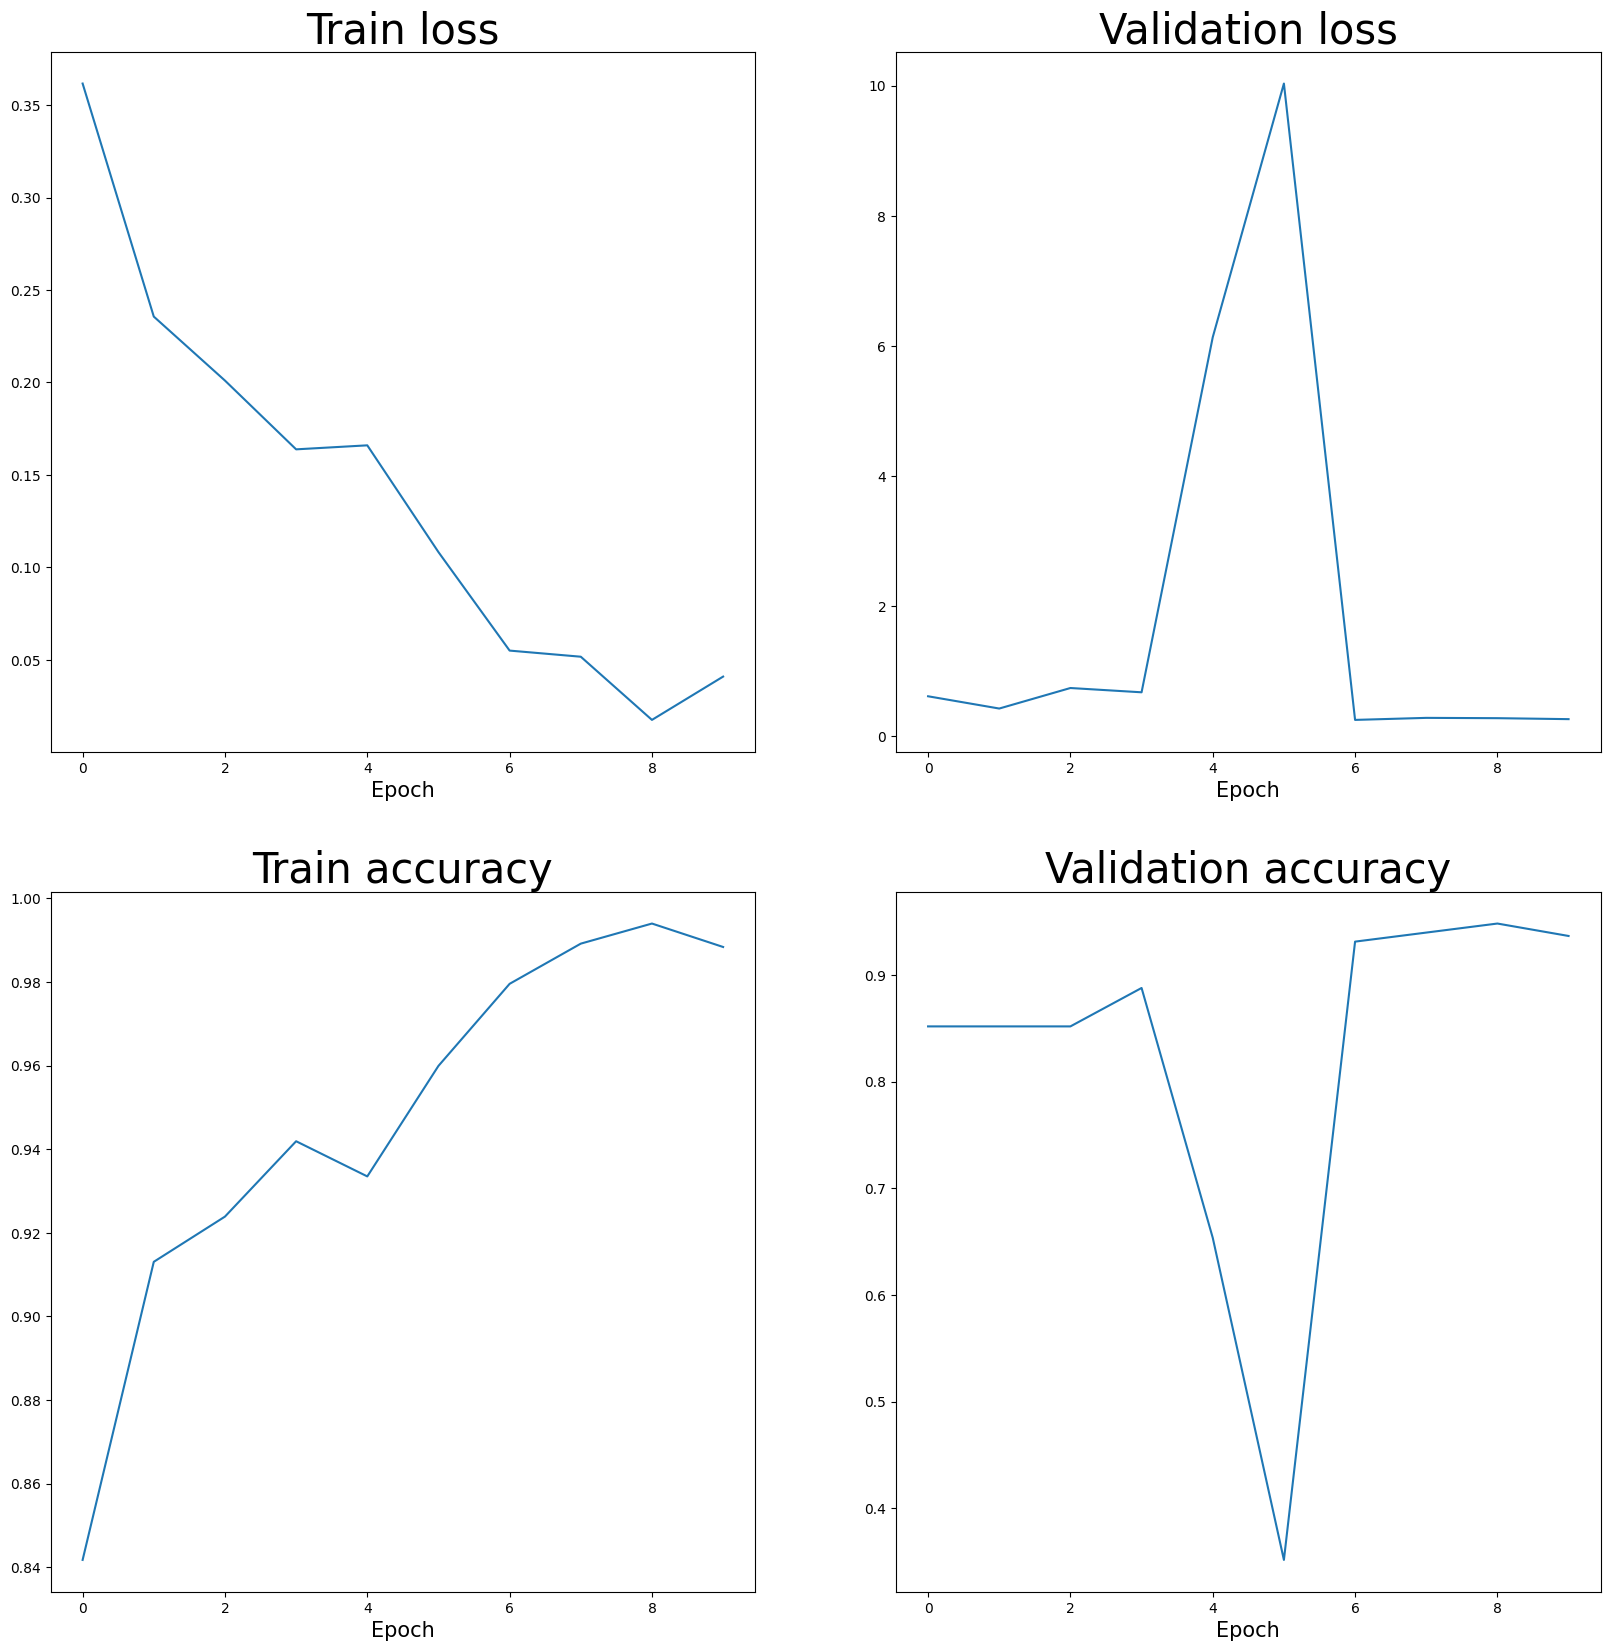

In [21]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

axes[0][0].plot(train_l)
axes[0][0].set_title("Train loss", fontsize=30)
axes[0][0].set_xlabel("Epoch", fontsize=15)

axes[0][1].plot(val_l)
axes[0][1].set_title("Validation loss", fontsize=30)
axes[0][1].set_xlabel("Epoch", fontsize=15)

axes[1][0].plot(train_accuracy)
axes[1][0].set_title("Train accuracy", fontsize=30)
axes[1][0].set_xlabel("Epoch", fontsize=15)

axes[1][1].plot(val_accuracy)
axes[1][1].set_title("Validation accuracy", fontsize=30)
axes[1][1].set_xlabel("Epoch", fontsize=15)

In [22]:
preds_arr, incorrect_samples = test_model_for_each_participant(mobilenet, test_data)

100%|██████████| 72/72 [00:18<00:00,  3.91it/s]

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        21
           1       0.98      0.98      0.98        51

    accuracy                           0.97        72
   macro avg       0.97      0.97      0.97        72
weighted avg       0.97      0.97      0.97        72



In [23]:
from pydub import AudioSegment

def test_model_no_chunks(model, test_data):
    model = model.to("cpu")
        
    model.eval()

    test_data["ID"] = test_data["file_name"].apply(
        lambda x: str(x).split("-")[0] + str(x).split("-")[1])
    test_data.head()
    IDs = test_data["ID"].unique()

    all_preds_aggr = []
    all_labels_aggr = []
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for participant_id in tqdm(IDs):
            participant_samples = test_data[test_data["ID"] == participant_id]
            preds_aggr = []
            labels_aggr = []
            for ind, participant_sample in participant_samples.iterrows():

                sgnl_path = participant_sample["file_name"]

                if participant_sample['label'] == 0:
                    sgnl_path = os.path.join(NORM_DIR, sgnl_path)
                else:
                    sgnl_path = os.path.join(APHASIA_DIR, sgnl_path)
                    
                # y, sr = librosa.load(sgnl_path, sr=8_000)
                audio = AudioSegment.from_file(sgnl_path, format="3gp")
                y = train_dataset.preprocess(audio)

                pred = model(y[None, None, ...]).detach().numpy().squeeze().argmax(axis=-1)
                
                labels_aggr.append(participant_sample['label'])
                preds_aggr.append(pred)

            pred = scipy.stats.mode(np.array(preds_aggr))

            all_preds_aggr.append(pred.mode)
            all_labels_aggr.append(labels_aggr[0])
            
            all_preds.extend(preds_aggr)
            all_labels.extend(labels_aggr)
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    print("Without aggr")
    print(classification_report(all_labels, all_preds))
    
    print("With aggr")
    print(classification_report(all_labels_aggr, all_preds_aggr))
    
    return all_preds, all_preds_aggr

In [24]:
test_model_no_chunks(mobilenet, test_data)

100%|██████████| 72/72 [00:13<00:00,  5.52it/s]

Without aggr
              precision    recall  f1-score   support

           0       0.89      0.76      0.82        42
           1       0.93      0.97      0.95       130

    accuracy                           0.92       172
   macro avg       0.91      0.87      0.88       172
weighted avg       0.92      0.92      0.92       172

With aggr
              precision    recall  f1-score   support

           0       0.89      0.81      0.85        21
           1       0.92      0.96      0.94        51

    accuracy                           0.92        72
   macro avg       0.91      0.89      0.90        72
weighted avg       0.92      0.92      0.92        72



(array([0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 [0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1])

### False Negative and False Positive samples

In [25]:
incorrect_samples

[                file_name  label     ID
 16  N-0923-RAT-1-bike.wav      0  N0923
 17  N-0923-RAT-1-robb.wav      0  N0923,
                 file_name  label    ID
 101  A-389-RAT-1-bike.wav      1  A389
 102  A-389-RAT-2-robb.wav      1  A389]

In [26]:
simple_features = np.load(os.path.join(DATA_DIR, 'test_data_simple.npy'))
test_filenames = pd.read_csv(os.path.join(DATA_DIR, 'test_filenames.csv'))

In [27]:
error_idxes = [y for x in incorrect_samples for y in x.index]

In [28]:
simple_features[np.array(error_idxes)]

array([[ 2.37440000e+05,  4.00000000e+00,  5.93600000e+04,
        -2.37140000e+05,  5.00000000e+00, -4.74280000e+04,
        -1.00126508e+00],
       [ 9.32800000e+04,  5.00000000e+00,  1.86560000e+04,
        -9.29800000e+04,  6.00000000e+00, -1.54966667e+04,
        -1.00322650e+00],
       [ 1.34176000e+05,  7.00000000e+00,  1.91680000e+04,
        -1.33876000e+05,  8.00000000e+00, -1.67345000e+04,
        -1.00224088e+00],
       [ 2.25280000e+05,  8.00000000e+00,  2.81600000e+04,
        -2.24980000e+05,  9.00000000e+00, -2.49977778e+04,
        -1.00133345e+00]])

In [29]:
CHECKPOINTS_DIR = os.path.join("..", "checkpoints")
if not os.path.exists(os.path.join(CHECKPOINTS_DIR, "mobilenet_chkp")):
    os.makedirs(os.path.join(CHECKPOINTS_DIR, "mobilenet_chkp"))

torch.save(
    {
        'epoch': 10,
        'model_state_dict': mobilenet.state_dict(),
        # 'optimizer_state_dict': optimizer.state_dict(),
        # 'scheduler_state_dict': scheduler.state_dict(),
        'losses_train': train_l,
        'losses_val': val_l,
    },
    os.path.join(CHECKPOINTS_DIR, "mobilenet_chkp", "mobilenet" + "_" + f"{val_accuracy[-1]:.2f}" + '.pt'),)